In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('data_20240111_1845.csv', index_col='Date')
data.drop(['Adj Close','Volume'], axis=1, inplace=True)
data['T10Y2Y'] = data['T10Y2Y'] = pd.to_numeric(data['T10Y2Y'], errors='coerce')
data.dropna(inplace=True)

In [3]:
training = data.loc['2006-01-01':'2018-01-01']
testing = data.loc['2018-01-01':'2022-01-01']
print(f'total data: {data.shape[0]}')
print(f'training data: {training.shape[0]}')
print(f'testing data: {testing.shape[0]}')

total data: 3968
training data: 2998
testing data: 970


In [4]:
# define label
training = training.copy()
training['MA'] = training['Close'].rolling(window=20).mean()
training['pct_chg'] = training['MA'].pct_change()
training['label'] = training['pct_chg'].apply(lambda x: 1 if x > 0.00012 else (-1 if x < -0.00012 else 0))
training.dropna(inplace=True)
training.drop(['MA','pct_chg'], axis= 1, inplace=True)

training['label'] = training['label'].shift(-1)
training.dropna(inplace=True)

unique, counts = np.unique(training['label'].values, return_counts=True)
dict(zip(unique, counts))

{-1.0: 986, 0.0: 138, 1.0: 1853}

In [5]:
X_train, y_train = training.drop('label', axis=1),training['label']


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

param_grid = {
    'n_estimators': [50, 125, 250, 1000],
    'max_depth': [3, 5, 7, 10, 15, 20],
    'min_samples_leaf': [3, 5, 10, 15]
}

classifier = RandomForestClassifier()

# Create a TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=3)

grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV 1/3] END max_depth=3, min_samples_leaf=3, n_estimators=50;, score=0.419 total time=   0.3s
[CV 2/3] END max_depth=3, min_samples_leaf=3, n_estimators=50;, score=0.683 total time=   0.4s
[CV 3/3] END max_depth=3, min_samples_leaf=3, n_estimators=50;, score=0.664 total time=   0.4s
[CV 1/3] END max_depth=3, min_samples_leaf=3, n_estimators=125;, score=0.426 total time=   0.7s
[CV 2/3] END max_depth=3, min_samples_leaf=3, n_estimators=125;, score=0.681 total time=   0.9s
[CV 3/3] END max_depth=3, min_samples_leaf=3, n_estimators=125;, score=0.665 total time=   1.0s
[CV 1/3] END max_depth=3, min_samples_leaf=5, n_estimators=50;, score=0.429 total time=   0.3s
[CV 2/3] END max_depth=3, min_samples_leaf=5, n_estimators=50;, score=0.681 total time=   0.3s
[CV 1/3] END max_depth=3, min_samples_leaf=3, n_estimators=250;, score=0.430 total time=   1.4s
[CV 3/3] END max_depth=3, min_samples_leaf=5, n_estimators=50;, score=0.661 tot

In [6]:
model = grid_search.best_estimator_

In [7]:
# define label for testing set
testing = testing.copy()
testing['MA'] = testing['Close'].rolling(window=20).mean()
testing['pct_chg'] = testing['MA'].pct_change()
testing['label'] = testing['pct_chg'].apply(lambda x: 1 if x > 0.00012 else (-1 if x < -0.00012 else 0))
testing.dropna(inplace=True)
testing.drop(['MA','pct_chg'], axis= 1, inplace=True)

testing['label'] = testing['label'].shift(-1)
testing.dropna(inplace=True)

unique, counts = np.unique(testing['label'].values, return_counts=True)
dict(zip(unique, counts))

{-1.0: 265, 0.0: 38, 1.0: 646}

In [8]:
X_test, y_test = testing.drop('label', axis=1),testing['label']

predictions = model.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Accuracy
accuracy = accuracy_score(y_test, predictions)

# Precision, Recall, F1 Score (macro, micro, weighted)
precision_macro = precision_score(y_test, predictions, average='macro')
precision_micro = precision_score(y_test, predictions, average='micro')
precision_weighted = precision_score(y_test, predictions, average='weighted')

recall_macro = recall_score(y_test, predictions, average='macro')
recall_micro = recall_score(y_test, predictions, average='micro')
recall_weighted = recall_score(y_test, predictions, average='weighted')

f1_macro = f1_score(y_test, predictions, average='macro')
f1_micro = f1_score(y_test, predictions, average='micro')
f1_weighted = f1_score(y_test, predictions, average='weighted')

# Detailed classification report
report = classification_report(y_test, predictions)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision (Macro): {precision_macro}")
print(f"Precision (Micro): {precision_micro}")
print(f"Precision (Weighted): {precision_weighted}")
print(f"Recall (Macro): {recall_macro}")
print(f"Recall (Micro): {recall_micro}")
print(f"Recall (Weighted): {recall_weighted}")
print(f"F1 Score (Macro): {f1_macro}")
print(f"F1 Score (Micro): {f1_micro}")
print(f"F1 Score (Weighted): {f1_weighted}")
print("\nClassification Report:\n", report)

Accuracy: 0.7323498419388831
Precision (Macro): 0.4670274028092532
Precision (Micro): 0.7323498419388831
Precision (Weighted): 0.6913377226566866
Recall (Macro): 0.4328037073816617
Recall (Micro): 0.7323498419388831
Recall (Weighted): 0.7323498419388831
F1 Score (Macro): 0.43457053932271106
F1 Score (Micro): 0.7323498419388831
F1 Score (Weighted): 0.69536465172783

Classification Report:
               precision    recall  f1-score   support

        -1.0       0.65      0.38      0.48       265
         0.0       0.00      0.00      0.00        38
         1.0       0.75      0.92      0.83       646

    accuracy                           0.73       949
   macro avg       0.47      0.43      0.43       949
weighted avg       0.69      0.73      0.70       949



/Users/ddloveyou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ddloveyou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ddloveyou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ddloveyou/opt/anaconda3/li

In [9]:
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,949.0,1951.984679,386.737595,1324.260010,1653.630005,1776.219971,2276.969971,2803.899902
High,949.0,1964.119871,387.387303,1324.260010,1661.609985,1786.250000,2296.090088,2813.590088
Low,949.0,1939.518253,387.205902,1259.729980,1646.569946,1762.709961,2254.840088,2795.709961
Close,949.0,1952.645882,387.767955,1288.040039,1654.540039,1776.430054,2278.689941,2803.739990
sp500return,949.0,0.000514,0.013720,-0.127652,-0.004014,0.001236,0.006740,0.089683
CPIAUCSL,949.0,259.438751,7.988578,248.859000,252.772000,257.244000,262.650000,280.887000
FEDFUNDS,949.0,1.075869,0.964095,0.050000,0.080000,1.420000,1.950000,2.420000
mktrf,949.0,0.000628,0.013834,-0.120000,-0.004100,0.001200,0.007000,0.093400
smb,949.0,0.000078,0.007189,-0.035600,-0.004000,-0.000100,0.004200,0.054600
hml,949.0,-0.000303,0.010846,-0.050200,-0.005700,-0.000900,0.004900,0.067300


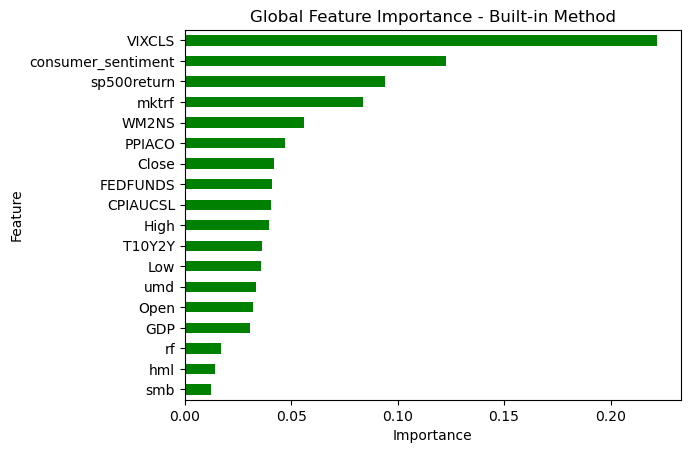

In [12]:
global_importances = pd.Series(model.feature_importances_, index=X_test.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")
plt.show()